# Efficient Data Representation by Selecting Prototypes with Importance Weights: An Implementation in PySpark

## Abstract

In this notebook I present a prototype selection algorithm proposed by Gurumoorthy, K. S. et al. ([[1]](#first_ref)) called _ProtoDash_, that is capable not only of selecting prototypes from a source dataset that are representative of a given target dataset, but can also assign non-negative weights to each one, thereby giving a sense of their relative importance in representing this target dataset. 

I implement the _ProtoDash_ algorithm using the Apache Spark Python API PySpark and in two experiments demonstrate its performance in application to a well-known large dataset: the MNIST Dataset of Handwritten Digits [[6]](#fifth_ref). In these experiments I first demonstrate that the _ProtoDash_ algorithm is capable of effectively representing an increasingly skewed target dataset based on a completely distinct and randomly sampled source dataset. Furthermore, I show that the algorithm's runtime in practice is largely driven by the computation of the mean inner product between the observations in the target and source datasets, with the actual selection of prototypes taking an increasingly small fraction of time as the dataset sizes increase by orders of magnitude.

## Table of contents <a class="anchor" id="oth-bullet"></a>
* [0) How can I run this notebook?](#fourth-bullet)
* [1) Introduction](#first0-bullet)
* [2) Problem statement](#first-bullet)
* [3) The ProtoDash algorithm](#second-bullet)
* [4) ProtoDash Time Complexity Analysis](#ss-bullet)
* [5) PySpark implementation of the ProtoDash algorithm](#fifth-bullet)
* [6) Applying the ProtoDash algorithm to the MNIST dataset](#sixth-bullet)
* [7) Conclusion](#ninth-bullet)
* [References](#tenth-bullet)

## 0) How can I run this notebook? <a class="anchor" id="fourth-bullet"></a>

First you will need to have __gsutil__ installed on your computer and ready to run. If you do not, please refer to the link below to get started:

 - https://cloud.google.com/storage/docs/gsutil_install

Now, given a choice of BUCKETNAME, CLUSTERNAME and given a PROJECTNAME, in your computer terminal enter:

    gsutil mb BUCKETNAME
    
Download the __my-actions.sh__ file from the project repository, then upload it to the created bucket with the terminal command:

    gsutil cp my-actions.sh gs://BUCKETNAME/
    
Again in a terminal, enter:

    gcloud dataproc clusters create CLUSTERNAME \
    --project PROJECTNAME \
    --bucket BUCKETNAME \
    --initialization-actions gs://dataproc-initialization-actions/jupyter/jupyter.sh,gs://dataproc-initialization-actions/python/pip-install.sh,gs://BUCKETNAME/my-actions.sh \
    --metadata 'PIP_PACKAGES= mnist scipy pandas qpsolvers cvxopt numpy' \
    --master-machine-type n1-standard-4 \
    --master-boot-disk-size 500 \
    --num-workers 5 \
    --worker-machine-type n1-standard-4 \
    --worker-boot-disk-size 500 
    
Once this is done navigate to your GCP portal, create an SSH tunnel and upload this notebook onto the created cluster.

[Back](#oth-bullet)

## 1) Introduction <a class="anchor" id="first0-bullet"></a>

Given a large and complex dataset, it can be useful to identify a subset of prototypical observations that can best offer a condensed overview of it. To see why consider the case of a machine learning model trained on a massive and noisy real world dataset. For reasons of interpretability it can be crucial to be able to efficiently extract observations from this noisy dataset that are particularly salient, or that essentially best 'describe' it, in order to better understand how the output of the machine learning model is obtained. More generally, the selection of a representative sample can  be useful for summarizing large noisy datasets, reducing these to a smaller, more compact and more informative subset.

The idea of selecting a subset of a large dataset that best offers this distilled view of the data has led to the development of algorithms that can identify a subset $S$ of a set $V$ that maximise a given scoring function $f(S).$ For prototype selection, this function $f(S)$ essentially provides a measure of the relevance of $S$ in accurately describing $V,$ while potentially also penalizing any redundancy in $S,$ to ensure compactness of the selected subset is maintained. Several such algorithms have been proposed, including [[1]](#first_ref), [[3]](#third_ref), [[8]](#eighth_ref).

In this notebook I closely examine one such algorithm called *ProtoDash*, proposed in recent work by [[1]](#first_ref), and implement it using PySpark, the Python API written to support Apache Spark. _ProtoDash_ is worthy of particular interest as it is demonstrated in [[1]](#first_ref) to be capable of selecting both representative samples and outliers that can succintly represent complex data, while assigning its selected prototypes non-negative weights, thus in essence ranking them in relevance. Furthermore, it has a clear computational advantage over the algorithm it replaces, *ProtoGreedy*, built in part on work by [[3]](#third_ref), bringing about a large runtime speedup both theoretically and practically while not compromising on quality of the subset selection. 

In this notebook I begin by formulating the problem statement underpinning _ProtoDash_, before presenting the algorithm and discussing its theoretical time complexity. I then show my implementation of the algorithm in PySpark. In an experiment section I wield the implemented algorithm onto a large dataset: the MNIST dataset of Handwritten Digits [[6]](#fifth_ref). I show that my implementation of the algorithm works in identifying prototypical observations from target datasets of varying sizes. Finally, I closely examine how performance of the algorithm is affected by varying dataset size.

[Back](#oth-bullet)

## 2) Problem statement <a class="anchor" id="first-bullet"></a>

To understand the problem that _ProtoDash_ aims to solve, suppose we have a dataset $V$ consisting of a number of observations (these could for example correspond to features). Our goal is to find a subset $S \subseteq V$ that can maximize a score function $f(S)$, where $f(S)$ will measure the relevance of $S$ in representing $V$ while favouring compact subsets with minimal redundancy, i.e. favour information-rich and compact subsets.

Denote by $X^{(1)}$ and $X^{(2)}$ the target and source datasets, respectively. We want to find a subset of prototypes $S$ from the source datast $X^{(2)}$ that can best describe the target dataset $X^{(1)}$ by maximising this score function $f(\cdot).$ Now denote by $\mathcal{X}$ the feature space from which observations in $X^{(1)}$ and $X^{(2)}$ are sampled, and consider a kernel function $k: \mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R}$ along with its corresponding reproducing kernel Hilbert space (RKHS) $\mathcal{K}.$ $\mathcal{K}$ has the inner product $k(x_i,x_j) = \langle \phi_{x_i}, \phi_{x_j} \rangle$ in which $\phi_{x}(y) = k(x,y) \in \mathcal{K}$ is a continuous linear function satisfying $\phi_x : h \rightarrow h(x) = \langle \phi_x, h \rangle $ for any function $h \in \mathcal{K}:\mathcal{X} \rightarrow \mathbb{R}.$

The approach proposed by [[1]](#first_ref) is to use the maximum mean discrepancy (MMD) [[2]](#second_ref) as the basis for the scoring function $f(\cdot)$. The MMD measures the distance between two probability distributions $p$ and $q$ by

\begin{align}
MMD(\mathcal{K},p,q) = \sup_{h \in \mathcal{K}}\langle h, \mathbf{\mu}_p - \mathbf{\mu}_q \rangle,
\end{align}

where $\mathbf{\mu}_p = \mathbb{E}_{x \sim p}[\phi_x].$ Now since $\mathbf{\mu}_p$ is unknown in the case of a real world dataset, CITE propose to approximate $\mathbf{\mu}_p$ by a weighted combination of $m$ samples in a subset $Z\subseteq X^{(2)}.$ The approximation is then given by $\mathbf{\mu}_p(x) \approx \sum_{j:z_j \in Z} w_j k(z_j,x)$ with $w_j \geq 0$ is a weight of the sample $z_j \in X^{(2)}.$ Therefore the key to minimizing the sample MMD is to choose the most appropriate set of prototypes $Z \subseteq X^{(2)}$ and corresponding non-negative weights $w_j.$

Indexing the elements in $X^{(2)}$ from 1 to $n^{(2)} = |X^{(2)}|,$ and for any $Z \subseteq X^{(2)},$ denote $L_Z \subseteq [n^{(2)}] = \{1,2,\cdots,n^{(2)} \}$ the set containing its indices. We define the function:

\begin{align}
l(w) = w^T\mathbf{\mu}_p - \frac{1}{2}w^TKw
\end{align}

where $K_{i,j} = k(y_i,y_j)$ and $\mu_{p,j} = \frac{1}{n^{(1)}}\sum_{x_i \in X^{(1)}}k(x_i,y_j)$ for any $y_j \in X^{(2)}$ is the estimation of the mean $\mu_p$. Our previously described goal of selecting the best subset $Z$ can thus be formulated as follows: We look to find an index set $L_Z$ of cardinality $|L_Z|=m$ with a corresponding weights vector $w$ such that the function $f:2^{[n^{(2)}]} \rightarrow \mathbb{R}^+$ defined by

\begin{align}
f(L_Z) \equiv \max_{w: supp(w) \in L_Z, w\geq 0} l(w)
\end{align}

is maximized. Note that here $supp(w) = \{j : w_j>0 \}.$ The maximizer for the set $L_Z$ is denoted by $\zeta^{(L_Z)}.$ This leads us to the presentation of the algorithm, which aims to accomplish this task.

[Back](#oth-bullet)

## 3) The ProtoDash algorithm <a class="anchor" id="second-bullet"></a>

The ProtoDash algorithm proposed in [[1]](#first_ref) is shown in the image below. 

<img src="algorithm.png" alt="Drawing" style="width: 800px;"/>

It can be understood as follows. First, the algorithm takes as inputs a specific number of prototypes to select $m$, a target dataset $X^{(1)}$ and a source dataset $X^{(2)}.$ From the source dataset $X^{(2)}$ the algorithm selects the observation $j^*$ for which the gradient of our previously described objective function $\nabla l(w)_{j^*}$ is the largest from all the set of candidate observations. Having selected this best element $j^*$, the optimal weights vector $\zeta^{L\cup\{j^*\}}$ is computed so as to maximize $f(L\cup{j^*})$. This procedure is iteratively repeated until $|L|=m$ or the lower bound $\epsilon$ on the increase in $f(\cdot)$ is crossed.

The appeal of this algorithm is that it offers a single framework in which to identify both representative observations and outliers since it assigns non-negative weights to all selected prototypes, allowing to rank them in order of importance. Moreover, it also lets us identify representative prototypes for a dataset $A$ from a distinct dataset $B$, with potentially useful applications to settings with covariate shift, for example in the case of massive datasets of real world time series. Finally, the ProtoDash algorithm offers a two orders of magnitude computational speedup over the ProtoGreedy algorithm (an extension of the algorithm proposed in [[3]](#third_ref)) while still being demonstrated to maintain prototype selection quality.

[Back](#oth-bullet)

## 4) ProtoDash Time Complexity Analysis <a class="anchor" id="ss-bullet"></a>

The breakdown of the ProtoDash algorithm's time complextiy is as follows.
 - In order to run the ProtoDash algorithm we first need to calculate the mean inner product of $X^{(1)}$ with every instance in $X^{(2)}.$ For large sized datasets this operation can be parallized and thus sped up, but its theoretical time complexity nonetheless is $\mathcal{O}(n^{(1)}n^{(2)}),$ where $n^{(i)}$ denotes the number of observations in dataset $X^{(i)}$ for $i=1,2.$

 - For the kernel matrix $K,$ the time complexity of building it is $\mathcal{O}(mn^{(2)})$ as inner products need to be computed within $X^{(2)}$ for each of the $m$ iterations of the algorithm.

 - The selection of the next best observation at iteration $i$ necessitates to evaluate the gradient for each one of $(n^{(2)} - i - 1)$ observations with each evaluation having time complexity $\mathcal{O}(i),$ since it requires calculating the inner product with the previous $i-1$ prototypes. Therefore finding $m$ such prototypes has time complexity $\mathcal{O}(m^2n^{(2)}).$

 - Furthermore, for each iteration $i$ we need to solve a quadratic optimisation problem, achievable in $\mathcal{O}(i^3).$ This step therefore has time complexity $\mathcal{O}(m^4).$

Therefore, combining the time complexity for each step we have that the ProtoDash algorithm has time complexity $\mathcal{O}(n^{(2)}(n^{(1)}+m^2)+m^4).$

[Back](#oth-bullet)

## 5) PySpark implementation of the ProtoDash algorithm <a class="anchor" id="fifth-bullet"></a>

In this section I present my implementation of the ProtoDash algorithm using PySpark. 

First, I import relevant modules.

In [1]:
# relevant imports
import time
import mnist
import numpy as np
import pandas as pd
from pyspark.mllib.linalg import DenseVector
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, FloatType, StructType, StructField, LongType
from qpsolvers import solve_qp
from cvxopt.solvers import qp
from cvxopt import matrix, spmatrix
import matplotlib.pyplot as plt
from textwrap import wrap

import warnings
warnings.filterwarnings("ignore")

My implementation of the algorithm relies on the following set of helper functions.

In [2]:
def create_vec_rdd(X, part=4):
    """
    Function returning a DenseVector RDD from a dataset X.
    
    Args:
    -X: a dataset with rows corresponding to observations and columns corresponding to features.
    -part: n of partitions.
    
    Returns:
    the RDD for X
    """
    X_rdd = (sc.parallelize(X, part)
             .map(lambda x: DenseVector(x))
             .zipWithIndex())
    return X_rdd


def mean_inner_product(inp,sigma,n):
    """
    Function computing the gaussian kernel inner product of a vector in Y vs.
    a vector in X, divided by n the total number of observations in X.
    """
    index_1 = inp[0][1]
    inner_product = float(np.exp(inp[0][0].squared_distance(inp[1][0])/(-2*sigma**2))/n)
    return (index_1, inner_product)


def inner_product(inp,sigma):
    """
    Function computing the gaussian kernel inner product of a vector vs.
    another.
    """
    index_1 = inp[0][1]
    index_2 = inp[1][1]
    inner_product = float(np.exp(inp[0][0].squared_distance(inp[1][0])/(-2*sigma**2)))
    return (index_1, [(index_2, inner_product)])


def weighted_sum(inp,w_arr):
    """
    compute the weighted sum of matrix values for a set of indices and weights.
    Note it is fine using a list comprehension here since the number of prototypes m << |X^{(1)}|.
    """
    return float(np.sum(np.array([x[1] for x in inp])*w_arr))


def udf_weighted_sum(w_arr):
    """
    UDF instance of the weighted_sum function.
    """
    return F.udf(lambda l: weighted_sum(l,w_arr))


def merge_lists(x, y):
    """
    merge lists.
    """
    return sorted(x+y, key=lambda tup: tup[0])


# Create UDF corresponding to merge_lists function.
DType = ArrayType(StructType([StructField("_1", LongType()), StructField("_2", FloatType())]))
udf_merge_lists = F.udf(merge_lists, DType)


def optimize(K, u, opt_w0, init_val, max_w=10000):
    """
    Function solving quadratic optimization problem posed by l(w).
        
    Args:
    -K: inner product matrix
    -u: mean inner product of each prototype
    -opt_w0: initial weights vector
    -init_val: starting run
    -max_w: an upper bound on weight value
    
    Returns:
    -weights and the objective value
    """
    dim = u.shape[0]
    low_b = np.zeros((dim, 1))
    upper_b = max_w * np.ones((dim, 1))
    x_init = np.append( opt_w0, init_val / K[dim-1, dim-1] )
    G = np.vstack((np.identity(dim), -1*np.identity(dim)))
    h = np.vstack((upper_b, -1*low_b))

    # solve constrained quadratic problem
    soltn = solve_qp(K, -u, G, h, A = None, b = None , solver = 'cvxopt' , initvals = x_init )
    
    # calculate the objective function value for optimal solution
    x_sol = soltn.reshape( soltn.shape[0], 1 )
    q = - u.reshape( u.shape[0], 1 )
    obj_value = 1/2 * np.matmul(np.matmul(x_sol.T, K), x_sol) + np.matmul(q.T, x_sol)
    
    return ( soltn, obj_value[0,0] )

Below is the ProtoDash algorithm.

In [3]:
def ProtoDashSpark(X,Y,m,sigma,partitions=20,verbose=True):
    """
    PySpark implementation of the ProtoDash algorithm derived in:
    
    Gurumoorthy, Karthik S., et al. ,
    "Efficient Data Representation by Selecting Prototypes with Importance Weights." 
    2019 IEEE International Conference on Data Mining (ICDM). IEEE, 2019.
    
    Args:
    -X (RDD of indexed DenseVector rows): Target dataset/ the dataset to be represented.
    -Y (RDD of indexed DenseVector rows): Source dataset/ the dataset to select prototypes from.
    -m (integer): total number of prototypes to select.
    -sigma (strictly positive float): gaussian kernel parameter.
    -partitions (integer): number of RDD partitions to compute inner product RDDs with.
    -verbose (boolean): whether or not to print the cumulative number of prototypes selected at each iteration.
    
    Returns:
    -L (integer list): the set of indices corresponding to selected prototypes.
    -w (float list): the optimal set of weights corresponding to each selected prototype.
    """
    
    # initialise algorithm starting time
    start_time = time.time()
        
    # get count of observations in X and Y
    n_Y = Y.count()
    n_X = X.count()
    
    # build mu DataFrame
    mu_df = (Y.cartesian(X)
              .map(lambda x: mean_inner_product(x,sigma,n_X))
              .reduceByKey(lambda x,y: x+y)
              .toDF(["obs","mu"]))
            
    # initialise key variables
    L = np.zeros(m, dtype=int)        # set of prototype indices L
    w = np.zeros(m, dtype=float)      # set of optimal prototype weights
    f_eval = np.zeros(m, dtype=float) # set of the f(w) eval. at prototype selection
    n_L = 0                           # count of prototypes selected so far
        
    # find the index corresponding to the maximum mu value
    max_grad_0 = mu_df.orderBy(F.desc("mu")).limit(1).collect()[0]
        
    # collect values 
    L[n_L] = max_grad_0.obs 
    w[n_L] = max_grad_0.mu 
    f_eval[n_L] = 1/2 * max_grad_0.mu ** 2
    n_L += 1
            
    # select the row of Y corresponding to the first chosen index
    Y_row_j0 = Y.filter(lambda x: x[1]==L[:n_L]).collect()[0]
    
    # take its inner product with all rows of Y to build the starting K dataframe
    K_init_df = (Y.map(lambda x: inner_product((x,Y_row_j0),sigma))
                  .toDF(["obs","K"]))
    
    # join mu and K dataframes
    join_df = (mu_df.join(K_init_df, "obs")
                    .repartition(partitions))
    
    # cache join_df as it is reused often
    join_df.cache()
        
    # compute the new gradient vector
    grad_df = (join_df.withColumn("K_weighted", udf_weighted_sum(w[:n_L])(F.col("K")))
                      .withColumn("grad", F.col("mu") - F.col("K_weighted"))
                      .select("obs","grad"))
    
    # instantiate list of iteration runtimes
    iteration_times = [time.time() - start_time]
            
    # begin while loop
    while n_L < m:
        
        # instantiate iteration start time 
        iteration_start_time = time.time()
                
        # remove the rows that have an index already included in L
        grad_df = grad_df.filter(~grad_df.obs.isin([int(x) for x in L[:n_L]]))

        # find the row that has the maximum value in the filtered gradient vector
        argmax_grad = grad_df.orderBy(F.desc("grad")).limit(1).collect()[0]

        # update L
        L[n_L] = argmax_grad.obs                

        # select the row of Y corresponding to the chosen index
        Y_row_j = Y.filter(lambda x: x[1]==L[n_L]).collect()[0]

        # take its inner product with all rows of Y to build new K
        K_int_df = (Y.map(lambda x: inner_product((x,Y_row_j),sigma))
                     .toDF(["obs","new_K_col"]))

        # add new K col to previous K col
        join_df = (join_df.join(K_int_df, "obs")
                          .withColumn("K_merged", udf_merge_lists(F.col("K"), F.col("new_K_col")))
                          .select("obs", "mu", "K_merged")
                          .withColumnRenamed("K_merged", "K"))

        # cache new joined_df
        join_df.cache()

        # increment n_L
        n_L +=1 
        
        # sort L
        L[:n_L] = sorted(L[:n_L])

        if verbose is True and n_L % 5==0:
                print( "Prototypes selected - "+str(n_L) )

        # take max gradient val.
        max_grad = argmax_grad.grad

        # filter join dataframe for given indices in L
        filt_df = (join_df.filter(join_df.obs.isin([int(x) for x in L[:n_L]]))
                          .orderBy(F.col("obs").asc()))

        # take mu vector
        mu_arr = np.array(filt_df.select("mu").collect(), dtype=float)

        # take K matrix
        K_mat = np.array(filt_df.rdd
                                 .map(lambda x: [y[1] for y in x[2]])
                                 .collect(), dtype=float )
        
        # find optimal weights for the index set L
        opt_res = optimize(K_mat, mu_arr, w[:n_L-1], max_grad)
        (w[:n_L], f_eval[n_L-1]) = opt_res[0], -opt_res[1]

        # compute gradient vector with new optimal weights
        grad_df = (join_df.withColumn("K_weighted", udf_weighted_sum(w[:n_L])(F.col("K")))
                          .withColumn("grad", F.col("mu") - F.col("K_weighted"))
                          .select("obs","grad"))
        
        # record iteration time in seconds
        iteration_times.append(time.time() - iteration_start_time)
        
    # tuple of indices and their corresponding weight, sorted by weight in descending order.
    res = sorted([(w[i],L[i]) for i in range(m)], key=lambda tup: -tup[0])
    
    # measure total algorithm runtime in seconds
    total_time = time.time() - start_time
           
    # return tuple of index set L and optimal weight set w, set of f_eval and list of runtimes.
    return res, f_eval, [iteration_times, total_time]

[Back](#oth-bullet)

## 6) Application of the ProtoDash algorithm on the MNIST dataset <a class="anchor" id="sixth-bullet"></a>

In this section I demonstrate how the ProtoDash algorithm I have implemented in PySpark can be used in practice to efficiently identify prototypes in a large dataset. 


To demonstrate this, I will be using the MNIST Dataset of Handwritten digits. This dataset - which can be found in [[6]](#fifth_ref) - consists of a training set of 60,000 labelled examples of handwritten digits and a test set of 10,000 similar labelled examples. Each of the MNIST observations consists of a 28$\times$28 float matrix.

In [4]:
# collect MNIST train/test sets
train_images = np.array(mnist.train_images(), dtype='float')
train_labels = mnist.train_labels()

test_images = np.array(mnist.test_images(), dtype='float')
test_labels = mnist.test_labels()

Below is shown the shape of the MNIST dataset.

In [5]:
print( train_images.shape )
print( test_images.shape )

(60000, 28, 28)
(10000, 28, 28)


Examples of plotted observations in the MNIST dataset are shown below:

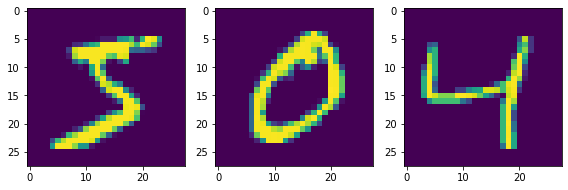

In [6]:
# take three MNIST observations
first_image = train_images[0]
second_image = train_images[1]
third_image = train_images[2]

# plot the three observations
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,8))
ax1.imshow(first_image)
ax2.imshow(second_image)
ax3.imshow(third_image)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## First Experiment: Using ProtoDash to accurately represent increasingly skewed datasets

### Experiment description

In my first experiment, I follow an approach proposed in [[1]](#first_ref) on the MNIST dataset, that seeks to show that given a specific target MNIST dataset $X^{(1)}$ featuring an increasingly over-represented digit and a completely distinct source MNIST dataset $X^{(2)}$ in which no digit is oversampled, the ProtoDash algorithm can effectively identify prototypes in $X^{(2)}$ that capture the increased skewness in $X^{(1)}.$

The design of this experiment is as follows.
Using the MNIST training dataset of 60000 observations, I build multiple target datasets, each consisting of 5420 observations (note that 5420 is the total number of observations of the least frequent digit in MNIST). Each such target set I create is increasingly skewed, for percentages $p=30,50,70,90,100.$ That is, for a given $p$ and a specified digit, I ensure that $p$% of the target dataset consists of this pre-specified digit, with the remaining observations consisting of other randomly selected handwritten digits. That means that I create 5 target datasets, one for each value of $p$, and each with a fraction $p$% consisting of this digit. For example, if $p=30$ and I pre-specified the over-represented digit to be 5, then I create a target dataset in which $30$% of the observations correspond to the digit 5, while the remaining observations are other digits. Once I have finished building these target datasets, I randomly select 1500 observations from the MNIST test set, in order to form my source dataset. 

I use this source dataset to sample 50 prototypes for each target dataset, and look to see if the ProtoDash algorithm successfully captures the increasing skewness in the target set.

To undertake this experiment I first implement the function below.

In [29]:
def create_target_set(labels, images, digit, target_n, percentage):
    """
    This function creates a MNIST image dataset in which a specified percentage of the total observations
    correspond to a specific digit, while the remaining observations correspond to other randomly
    chosen digits.
    
    Args:
    -labels: the digit label for each MNIST image.
    -images: the MNIST image.
    -digit: a digit between 0 and 9.
    -target_n: the number of total observations required in the target dataset.
    -percentage: the percentage of images in the target dataset that correspond to the specified digit.
    
    Returns:
    -the target images.
    
    """
    
    # take integer number of obs. corresponding to digit
    n_dig = int( np.floor( percentage * target_n ) )
    
    # get indices corresponding to digit
    idx = np.where(labels == digit)[0]
    
    # reduce indices to specific %
    idx_red = idx[:n_dig]
    
    # slice images with index and reshape
    target_set_dig = images[idx_red,:]
    target_set_dig = np.reshape( target_set_dig, (target_set_dig.shape[0], 28*28))
    
    # get remaining indices
    rem = target_n - n_dig
    rem_ind = np.setdiff1d( np.arange(len(labels)), idx_red )[:rem]
    
    # fill the remaining observations with images corresponding to other digits
    target_set_non_dig = images[rem_ind]
    target_set_non_dig = np.reshape( target_set_non_dig, (target_set_non_dig.shape[0], 28*28))
    
    # create the dataset
    target_set = np.vstack((target_set_non_dig,target_set_dig))
    
    # shuffle it
    arr = np.arange(target_n)
    np.random.shuffle(arr)
    
    return target_set

I then fix key ProtoDash parameters.

In [30]:
m = 25           # number of prototypes for ProtoDash to select
part = 6         # number of Pyspark RDD partitions to use
sigma = 50       # gaussian kernel parameter

Note that the parameter $\sigma$ can be selected methodically using cross-validation, which is beyond the scope of this project. Further resource on effective cross-validation to choose $\sigma$ can be found in [[5]](#sixth_ref).

Now I fix some important variables for this experiment.

In [31]:
digit = 8            # the digit to be represented at different levels of percentage in the target dataset X_1
n_1 = 5420           # the number of observations in X_1
n_2 = 1500           # the number of observations in X_2
percentages = [.3, .5, .7, .9, 1.] # the percentages of X_1 that will correspond to the chosen digit

I then iteratively create the target datasets and run the ProtoDash algorithm to select $m=50$ prototypes from my source dataset to represent them.

In [32]:
# p = 30

# # select the target datasets
# target_set = create_target_set(train_labels, train_images, digit, n_1, p)

# # convert target and source datasets to RDDs
# target_rdd = create_vec_rdd(target_set, part)
# source_rdd = create_vec_rdd(source_set, part)

# # collect the indices of m prototypes along with their ascribed weight
# res, f = ProtoDashSpark(target_rdd, source_rdd, 10, 50, partitions=part,verbose=True)[:2]

In [33]:
# res

# plt.imshow( np.reshape(source_set[res[0][1]],(28,28)) )
# plt.show()

# #     ax1[i].imshow( np.reshape( source_set[exp_1_res_list[i][0][1],:], (28, 28)) )
# #     ax1[i].get_xaxis().set_ticks([])
# #     ax1[i].get_yaxis().set_ticks([])


In [ ]:
# list of experiment results
exp_1_res_list = []

# list of f_eval sequences
exp_1_f_eval_list = []

# set source dataset and labels
source_set = np.reshape( test_images[:n_2], (n_2, 28 * 28) )
source_labels = test_labels[:n_2]

# iterate through percentages
for p in percentages:
    
    # print percentage
    print (str(p*100)+"%")

    # select the target datasets
    target_set = create_target_set(train_labels, train_images, digit, n_1, p)

    # convert target and source datasets to RDDs
    target_rdd = create_vec_rdd(target_set, part)
    source_rdd = create_vec_rdd(source_set, part)

    # collect the indices of m prototypes along with their ascribed weight
    res, f = ProtoDashSpark(target_rdd, source_rdd, m, sigma, partitions=part,verbose=True)[:2]
    
    # collect the results
    exp_1_res_list.append(res)
    exp_1_f_eval_list.append(f)

30.0%


### Experiment results

Once this is completed, for each target dataset I plot the top 5 prototypes selected from my source dataset by the ProtoDash algorithm to represent each of my skewed target datasets. 

The ranking of ProtoDash prototypes is done in terms of the non-negative weight assigned to each prototype by the ProtoDash algorithm. That is, the prototype with the highest weight is ranked as the observation of the source dataset that is most representative of the target dataset. In the plot below for each skewed target dataset the 5 prototypes are shown in descending weight (i.e. relevance) from top to bottom. 

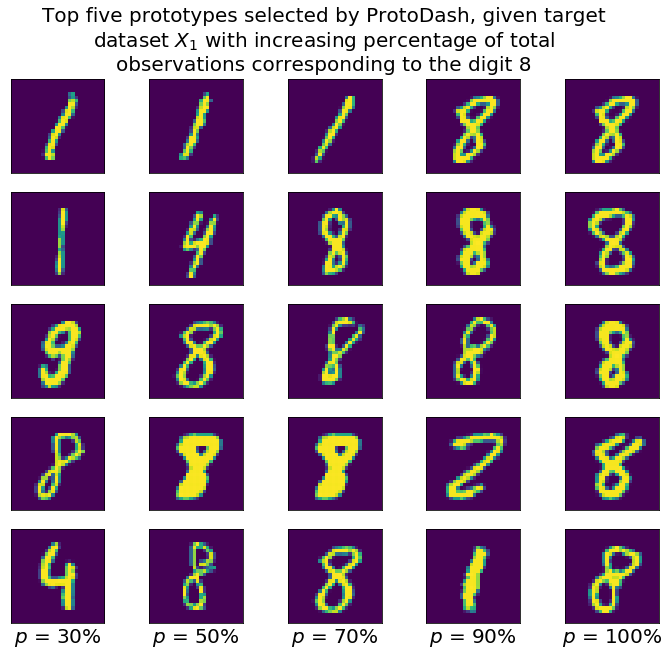

In [19]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 5, figsize=(12,10))

for i in range(len(percentages)):
    ax1[i].imshow( np.reshape( source_set[exp_1_res_list[i][0][1],:], (28, 28)) )
    ax1[i].get_xaxis().set_ticks([])
    ax1[i].get_yaxis().set_ticks([])

    ax2[i].imshow( np.reshape( source_set[exp_1_res_list[i][1][1],:], (28, 28)) )
    ax2[i].get_xaxis().set_ticks([])
    ax2[i].get_yaxis().set_ticks([])

    ax3[i].imshow( np.reshape( source_set[exp_1_res_list[i][2][1],:], (28, 28)) )
    ax3[i].get_xaxis().set_ticks([])
    ax3[i].get_yaxis().set_ticks([])

    ax4[i].imshow( np.reshape( source_set[exp_1_res_list[i][3][1],:], (28, 28)) )
    ax4[i].get_xaxis().set_ticks([])
    ax4[i].get_yaxis().set_ticks([])

    ax5[i].imshow( np.reshape( source_set[exp_1_res_list[i][4][1],:], (28, 28)) )
    ax5[i].get_xaxis().set_ticks([])
    ax5[i].get_yaxis().set_ticks([])

ax5[0].set_xlabel("$p$ = 30%", fontsize=20)
ax5[1].set_xlabel("$p$ = 50%", fontsize=20)
ax5[2].set_xlabel("$p$ = 70%", fontsize=20)
ax5[3].set_xlabel("$p$ = 90%", fontsize=20)
ax5[4].set_xlabel("$p$ = 100%", fontsize=20)

fig.suptitle("\n".join(wrap("Top five prototypes selected by ProtoDash, given target dataset $X_1$ with increasing percentage of total observations corresponding to the digit 8", 60)),
            fontsize=20)

plt.show()

From a simple visual inspection of this plot we can already observe that the ProtoDash algorithm is highly successful in representing an increasingly skewed dataset based purely on a completely distinct, un-skewed dataset. Indeed, as the percentage of skewness $p$ increases here from 30% to 100%, we can see that the ProtoDash algorithm adapts very quickly by increasingly selecting observations that correspond to the oversampled digit. Furthermore, from a cursory inspection it can be seen that the quality of the top prototype selected by ProtoDash gradually improves with increasing $p.$

In the Pandas DataFrame below I show for each actual percentage $p$ the percentage of $m$ prototypes selected by ProtoDash that correspond to our chosen oversampled digit. Corroborating our previous visual observations we can see that the algorithm increasingly selects our chosen digit from the source dataset as the target dataset becomes increasingly skewed towards it, demonstrating its ability to represent one dataset choosing prototypes from another one with a different distribution of observations.

In [21]:
prototype_p = [np.sum(source_labels[np.array([x[1] for x in exp_1_res_list[i]])]==digit)/m * 100 for i in range(len(percentages))]

pd.DataFrame({"p (%)":np.array(percentages)*100, "% of digit selected by ProtoDash":prototype_p})

,p (%),% of digit selected by ProtoDash
0,30.0,28.0
1,50.0,48.0
2,70.0,64.0
3,90.0,72.0
4,100.0,80.0


In the figure below, for each skewed target dataset I plot the ProtoDash objective function for increasing prototype dataset size $m.$ For all considered target datasets the objective function is strictly increasing at a decreasing rate, demonstrating that the ProtoDash algorithm satisfies the property of diminishing returns of the scoring function. That is, given a set $C$, two subsets $A \subset B \subset C$ and an observation $j \not \in B,$ we have that $f(A\cup\{j\}) - f(A) \geq f(B\cup\{j\}) - f(B)$ holds. This property is known as _submodularity_, and it can be readily seen from the concavity of the objective function plotted below. Furthermore, we can see that as the target dataset becomes increasingly skewed, the ProtoDash objective function reaches increasingly high values, demonstrating that it becomes increasingly easy for it to identify prototypes that best represent this increasingly uniform target set. This proves the algorithm is indeed responsive to and effectively adapting to the increased skewness in the target data.

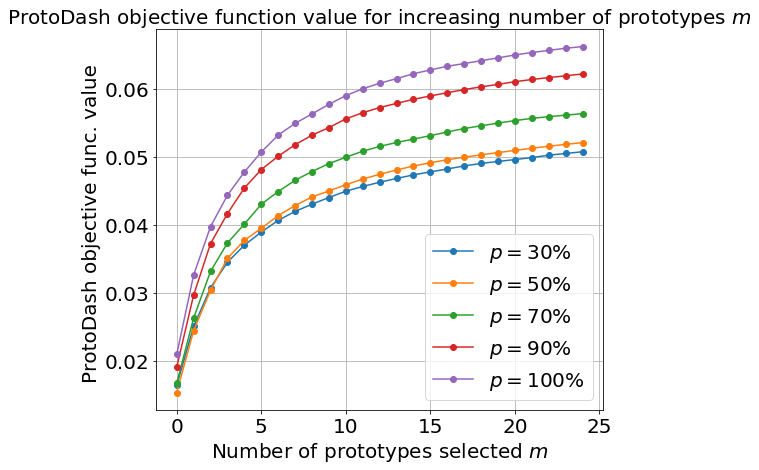

In [23]:
fig, ax = plt.subplots(figsize=(8,7))

for i in range(len(percentages)):
    ax.plot( exp_1_f_eval_list[i], 'o-' )
    
ax.tick_params(axis="both", which="major", labelsize=20)
ax.set_xlabel("Number of prototypes selected $m$", fontsize=20)
ax.set_ylabel("ProtoDash objective func. value ", fontsize=20)
plt.title("ProtoDash objective function value for increasing number of prototypes $m$",fontsize=20)
plt.grid()
plt.legend(["$p =$"+str(int(p*100))+"%" for p in percentages],fontsize=20)
plt.show()

[Back](#oth-bullet)

## Second experiment: Testing the speed of ProtoDash on increasingly large target datasets

### Experiment description

In this second experiment I examine the speed of my implementation of the ProtoDash algorithm. 

The experiment is designed as follows. By iteratively increasing $n_1$ (i.e. the number of observations in the target dataset $X_1$), I measure the runtime in seconds of the ProtoDash algorithm given the task of selecting $m=10$ representative prototypes from a completely distinct source dataset $X_2$ of size $n_2=1500$ (note this is the source dataset size used throughout [[1]](#first_ref)).

To undertake this experiment I start by fixing basic ProtoDash settings.

In [10]:
m = 10      # number of prototypes for ProtoDash to select
part = 8    # number of Pyspark RDD partitions to use
sigma = 200 # gaussian kernel parameter

I choose to test the following sizes for $n_1:$ 10, 50, 100, 500, 1000, 5000, 10000, 50000, to provide a clear idea of how ProtoDash runtime evolves for target datasets with sizes of different orders of magnitude.

In [11]:
# list of X_1 dataset sizes
n_1_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000]

# size of X_2 dataset
n_2 = 1500

I then iterate over the values of $n_1$ and collect the ProtoDash runtimes for each one.

In [12]:
# result list
exp_2_res_list = []

# loop through n_1 sizes
for n_1 in n_1_list:
    
    # print n_1
    print( "n_1 = " + str(n_1) )
    
    # get datasets
    X_1 = np.reshape( train_images[:n_1], (n_1, 28 * 28 ))
    X_2 = np.reshape( train_images[n_1:n_1+n_2], (n_2, 28 * 28))
        
    # create RDD datasets
    Y = create_vec_rdd(X_2, part)
    X = create_vec_rdd(X_1, part)
    
    # apply ProtoDash algorithm
    res = ProtoDashSpark(X,Y,m,sigma,part)
    
    # collect results
    exp_2_res_list.append(res)

n_1 = 10
Prototypes selected - 5
Prototypes selected - 10
n_1 = 50
Prototypes selected - 5
Prototypes selected - 10
n_1 = 100
Prototypes selected - 5
Prototypes selected - 10
n_1 = 500
Prototypes selected - 5
Prototypes selected - 10
n_1 = 1000
Prototypes selected - 5
Prototypes selected - 10
n_1 = 5000
Prototypes selected - 5
Prototypes selected - 10
n_1 = 10000
Prototypes selected - 5
Prototypes selected - 10
n_1 = 50000
Prototypes selected - 5
Prototypes selected - 10


### Experiment results

Below I plot the ProtoDash algorithm runtime in seconds as a function of the total number of observations $n_1$ in target dataset $X^{(1)}.$ It can be seen that for $n_1\geq 1000$ the total ProtoDash runtime appears to increase linearly with $n_1$, which is a result consistent with the previously described theoretical ProtoDash time complexity of $\mathcal{O}(n^{(1)}n^{(2)} + m^4 + m^2n^{(2)}).$ Indeed, given this theoretical time complexity, it can easily be seen that if we keep $m, n^{(2)}$ fixed but gradually increase $n^{(1)}$ until we have that $n^{(1)}>>m,n^{(2)},$ we end up with a time complexity of $\mathcal{O}(n^{(1)})$, i.e. a runtime linear in $n^{(1)}$ as in the plot below.

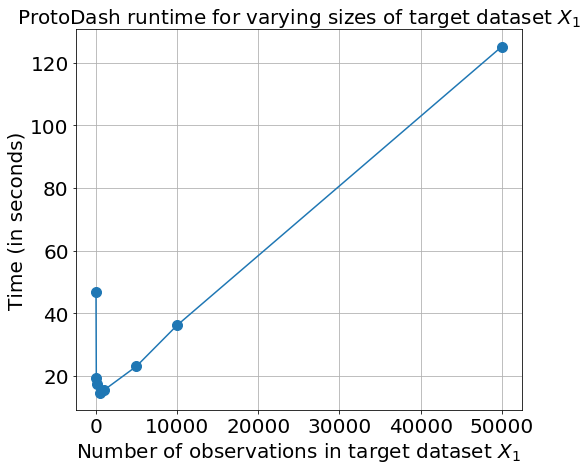

In [15]:
fig, ax = plt.subplots(figsize=(8,7))
ax.plot( n_1_list, [res_i[2][1] for res_i in exp_2_res_list], 'o-', markersize=10)
ax.set_title("ProtoDash runtime for varying sizes of target dataset $X_1$", fontsize=20)
ax.set_xlabel("Number of observations in target dataset $X_1$", fontsize=20)
ax.set_ylabel("Time (in seconds)", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.grid()
plt.show()

The actual values of the ProtoDash algorithm runtime in seconds for increasing sizes of $n_1$ are given in the pandas DataFrame below.

In [17]:
pd.DataFrame({"$n_1$": n_1_list, " ProtoDash Runtime (s)": [res_i[2][1] for res_i in exp_2_res_list]})

,$n_1$,ProtoDash Runtime (s)
0,10,46.728925
1,50,19.237747
2,100,17.501685
3,500,14.753179
4,1000,15.519634
5,5000,23.136997
6,10000,36.187381
7,50000,125.088802


To show exactly which step of the ProtoDash algorithm takes up the largest fraction of its total runtime as $n_1$ increases, I plot below the ratio of the time taken to compute the mean inner-product vector $\mu$ (which as a reminder has theoretical time complexity $\mathcal{O}(n^{(1)}n^{(2)})$) with the total time taken to run the ProtoDash algorithm. I plot this ratio as a function of increasing $n^{(1)}$. 

From the plot we can readily see that as $n^{(1)}$ increases, the computation of the mean inner product vector $\mu$ (with time complexity $\mathcal{O}(n^{(1)}n^{(2)})$) takes up an increasingly large fraction of the total ProtoDash runtime, demonstrating that it is by far the most costly operation undertaken in ProtoDash. As $n^{(1)}$ or $n^{(2)}$ increase asymptotically to infinity this is always true, simply because of the fact that for prototype selection we typically seek a fixed $m << n^{(1)}, n^{(2)},$ so the time complexity as $n^{(1)},n^{(2)}$ increase must become $\mathcal{O}(n^{(1)}n^{(2)}).$

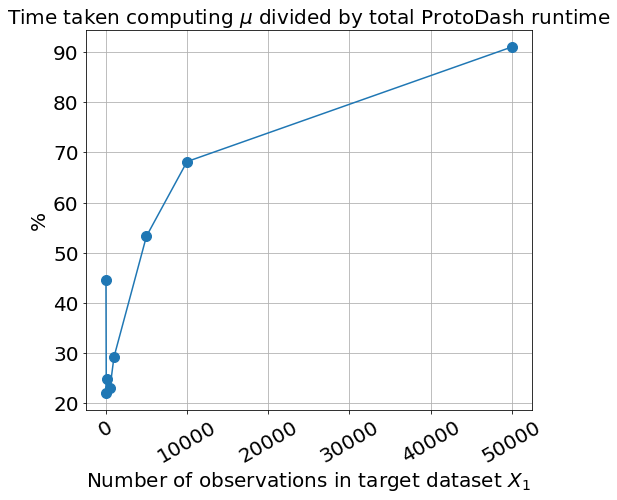

In [18]:
fig, ax = plt.subplots(figsize=(8,7))
ax.plot( n_1_list, [res_i[2][0][0]/res_i[2][1] * 100 for res_i in exp_2_res_list], 'o-', markersize=10)
ax.set_title("Time taken computing $\mu$ divided by total ProtoDash runtime", fontsize=20)
ax.set_xlabel("Number of observations in target dataset $X_1$", fontsize=20)
ax.set_ylabel("%", fontsize=20)
ax.tick_params(axis="x", rotation = 30)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.grid()
plt.show()

Now in the figure below I plot the runtime in seconds of the ProtoDash algorithm as a function of the number of prototypes to select ($m$), for different values of $n_1$. Note that in this plot the legend corresponds to the different values of $n_1$.


It is apparent here that once the mean inner product vector $\mu$ has been computed (this is done at the very start of the algorithm, prior to any prototype being selected), the runtimes for the different target dataset sizes are largely comparable, with the curve for each sharing the same slope approximately constant slope for increasing $m$. This demonstrates that once $\mu$ has been computed and thus the most computationally costly step has been completed, selecting any given $m$ will take the same runtime regardless of the target dataset size.

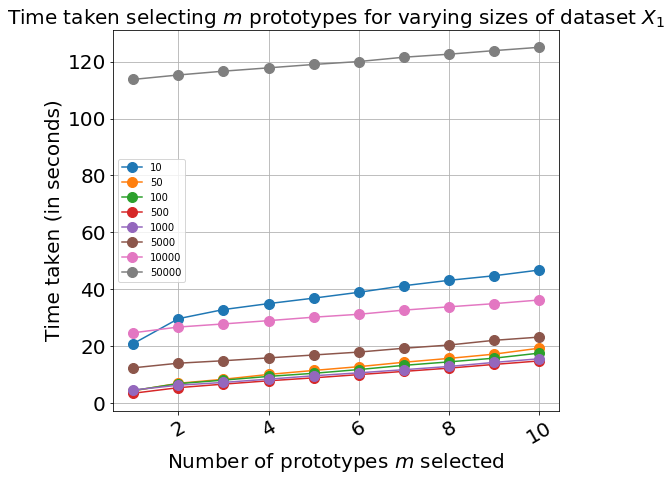

In [22]:
fig, ax = plt.subplots(figsize=(8,7))
for i in range(len(n_1_list)):
    ax.plot( range(1,11), np.cumsum( exp_2_res_list[i][2][0] ), 'o-', markersize=10)
ax.set_title("Time taken selecting $m$ prototypes for varying sizes of dataset $X_1$", fontsize=20)
ax.set_xlabel("Number of prototypes $m$ selected", fontsize=20)
ax.set_ylabel("Time taken (in seconds)", fontsize=20)
ax.legend(n_1_list)
ax.tick_params(axis="x", rotation = 30)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.grid()
plt.show()

[Back](#oth-bullet)

## 7) Conclusion <a class="anchor" id="ninth-bullet"></a>

In this notebook I have presented the problem statement underpinning an efficient prototype selection algorithm called $\textit{ProtoDash}$ and implemented the algorithm itself using Apache Spark via the API PySpark. I have shown that my implementation of the algorithm is successfully able to represent a target dataset based on a completely different source dataset, by demonstrating the application of my implemented ProtoDash algorithm on the MNIST dataset. Furthermore, I have examined the performance of my implementation of the $\textit{ProtoDash}$ algorithm in terms of speed, effectively showing that it matches the theoretical time complexity of $\textit{ProtoDash}$ laid out by [[1]](#first_ref).

[Back](#oth-bullet)

## References <a class="anchor" id="tenth-bullet"></a>

[1] Gurumoorthy, Karthik S., et al. "Efficient Data Representation by Selecting Prototypes with Importance Weights." 2019 IEEE International Conference on Data Mining (ICDM). IEEE, 2019. <a class="anchor" id="first_ref"></a>

[2] Gretton, Arthur, et al. "A kernel method for the two-sample-problem." Advances in neural information processing systems. 2007. <a class="anchor" id="second_ref"></a>

[3] Kim, Been, Rajiv Khanna, and Oluwasanmi O. Koyejo. "Examples are not enough, learn to criticize! criticism for interpretability." Advances in neural information processing systems. 2016. <a class="anchor" id="third_ref"></a>

[5] Friedman, J., Hastie, T., & Tibshirani, R. (2001). The elements of statistical learning (Vol. 1, No. 10). New York: Springer series in statistics. <a class="anchor" id="sixth_ref"></a>

[6] The MNIST Database of Handwritten Digits: http://yann.lecun.com/exdb/mnist/ <a class="anchor" id="fifth_ref"></a>

[7] Koh, P. W., & Liang, P. (2017, August). Understanding black-box predictions via influence functions. In Proceedings of the 34th International Conference on Machine Learning-Volume 70 (pp. 1885-1894). JMLR. org. <a class="anchor" id="eighth_ref"></a>

[Back](#oth-bullet)